## Multi-Class Prediction of Obesity Risk

Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

Your Goal: The goal of this competition is to use various factors to predict obesity risk in individuals, which is related to cardiovascular disease. Good luck!

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import optuna


## 1. Загрузка и обработка данных

Загружаем данные:

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print('df_train shape:', df_train.shape)
print('df_test shape:', df_test.shape)
display(df_train.head())
display(df_train.info())

df_train shape: (20758, 18)
df_test shape: (13840, 17)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

None

Пояснения к некторым переменным:

* FAVC - Frequent consumption of high caloric food
* FCVC - Frequency of consumption of vegetables
* NCP - Number of main meals
* CAEC - Consumption of food between meals
* CH2O - Consumption of water daily
* SCC - Calories consumption monitoring
* FAF - Physical activity frequency
* TUE - Time using technology devices
* CALC - Consumption of alcohol
* MTRANS - Transportation used

Кол-во классов и их распределение:

In [5]:
# таргеты (7 классов) +- сбалансированы
df_train.NObeyesdad.value_counts()

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

Удалим не нужный признак id и закодируем бинарные переменные и целевую переменную:

In [6]:
# удаляем неинформативный признак
df_train = df_train.drop('id', axis=1)
# сохраним id и теста для дальнейшего sample submission
id_sample_submission = df_test['id']
# удаляем неинформативный признак
df_test = df_test.drop('id', axis=1)

# кодируем бинарные пременные
df_train.Gender = df_train.Gender.apply(lambda x: 1 if x == 'Male' else 0)
df_train.family_history_with_overweight = df_train.family_history_with_overweight.apply(lambda x: 1 if x == 'yes' else 0)
df_train.FAVC = df_train.FAVC.apply(lambda x: 1 if x == 'yes' else 0)
df_train.SMOKE = df_train.SMOKE.apply(lambda x: 1 if x == 'yes' else 0)
df_train.SCC = df_train.SCC.apply(lambda x: 1 if x == 'yes' else 0)

df_test.Gender = df_test.Gender.apply(lambda x: 1 if x == 'Male' else 0)
df_test.family_history_with_overweight = df_test.family_history_with_overweight.apply(lambda x: 1 if x == 'yes' else 0)
df_test.FAVC = df_test.FAVC.apply(lambda x: 1 if x == 'yes' else 0)
df_test.SMOKE = df_test.SMOKE.apply(lambda x: 1 if x == 'yes' else 0)
df_test.SCC = df_test.SCC.apply(lambda x: 1 if x == 'yes' else 0)

# кодируем таргеты
def new_target(x):
    if x == 'Normal_Weight':
        return 0
    if x == 'Obesity_Type_I':
        return 1
    if x == 'Obesity_Type_II':
        return 2
    if x == 'Obesity_Type_III':
        return 3
    if x == 'Overweight_Level_I':
        return 4
    if x == 'Overweight_Level_II':
        return 5
    if x == 'Insufficient_Weight':
        return 6

df_train.NObeyesdad = df_train.NObeyesdad.apply(new_target)
df_train.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,0.000000,0.976473,Sometimes,Public_Transportation,5
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,1.000000,1.000000,no,Automobile,0
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,0.866045,1.673584,no,Public_Transportation,6


Сразу создадим функцию для "раскодирования" классов:

In [57]:
def get_target(x):
    if x == 0:
        return 'Normal_Weight'
    if x == 1:
        return 'Obesity_Type_I'
    if x == 2:
        return 'Obesity_Type_II'
    if x == 3:
        return 'Obesity_Type_III'
    if x == 4:
        return 'Overweight_Level_I'
    if x == 5:
        return 'Overweight_Level_II'
    if x == 6:
        return 'Insufficient_Weight' 

Закодируем переменные, которые характерезуют частоту употребления алкоголя и перекусов. Обратим внимание на то, что в тестовом наборе данных для переменной CALC есть категория "Always", таких наблюдений мало, заменим их на значение "Frequently": 

In [7]:
# меняем новую категорию в тестовом наборе 
df_test.CALC = df_test.CALC.apply(lambda x: 'Frequently' if x == 'Always' else x)

def get_frequent_category(x):
    if x == 'no':
        return 0
    if x == 'Sometimes':
        return 1
    if x == 'Frequently':
        return 2
    if x == 'Always':
        3

# кодируем категории
df_train.CAEC = df_train.CAEC.apply(get_frequent_category)
df_test.CAEC = df_test.CAEC.apply(get_frequent_category)

df_train.CALC = df_train.CALC.apply(get_frequent_category)
df_test.CALC = df_test.CALC.apply(get_frequent_category)

Закодируем оставшиеся категориальные переменные:

In [8]:
df_train = pd.get_dummies(df_train, dtype=int)
df_test = pd.get_dummies(df_test, dtype=int)

df_train.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1.0,0,...,0,0.000000,0.976473,1,5,0,0,0,1,0
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2.0,0,...,0,1.000000,1.000000,0,0,1,0,0,0,0
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1.0,0,...,0,0.866045,1.673584,0,6,0,0,0,1,0


## 2. Feature engineering

Создадим переменную связывающию рост и вес - индекс массы тела (BMI):

In [9]:
df_train['BMI'] = df_train.Weight / (df_train['Height'] ** 2)
df_test['BMI'] = df_test.Weight / (df_test['Height'] ** 2)

df_train['BMI'].describe()

count    20758.000000
mean        30.241842
std          8.333932
min         12.868541
25%         24.088223
50%         29.384757
75%         37.011168
max         54.997991
Name: BMI, dtype: float64

Создадим переменную связывающию частоту физической активности (FAF) и частоту использования технических устройств (TUE), такая переменная может показывать общую активность человека: 

In [10]:
df_train['Physical_Activity'] = df_train['FAF'] - df_train['TUE']
df_test['Physical_Activity'] = df_test['FAF'] - df_test['TUE']

df_train['Physical_Activity'].describe() 

count    20758.000000
mean         0.364990
std          1.021703
min         -2.000000
25%         -0.274914
50%          0.285889
75%          1.000000
max          3.000000
Name: Physical_Activity, dtype: float64

Создадим переменную связывающию частоту употребления овощей (FCVC) и кол-во приемов пищи (NCP), эта переменная может показывать пищевые привычки человека:

In [11]:
df_train['Meal_Habits'] = df_train['FCVC'] * df_train['NCP']
df_test['Meal_Habits'] = df_test['FCVC'] * df_test['NCP']

df_train['Meal_Habits'].describe()

count    20758.000000
mean         6.796596
std          2.356030
min          1.000000
25%          6.000000
50%          6.453894
75%          9.000000
max         12.000000
Name: Meal_Habits, dtype: float64

Также добавим переменные связывающие физическую активность, время использования тех.устройств с возрастом:

In [12]:
df_train['Tech_Age_Score'] = df_train['TUE'] / df_train['Age']
df_test['Tech_Age_Score'] = df_test['TUE'] / df_test['Age']

df_train['Activity_Age_Score'] = df_train['FAF'] / df_train['Age']
df_test['Activity_Age_Score'] = df_test['FAF'] / df_test['Age']

display(df_train['Tech_Age_Score'].describe())
display(df_train['Activity_Age_Score'].describe())

count    20758.000000
mean         0.028715
std          0.029408
min          0.000000
25%          0.000000
50%          0.022908
75%          0.047739
max          0.142857
Name: Tech_Age_Score, dtype: float64

count    20758.000000
mean         0.044832
std          0.040613
min          0.000000
25%          0.000320
50%          0.043478
75%          0.067184
max          0.214286
Name: Activity_Age_Score, dtype: float64

Посмотрим на матрицу корреляций итоговых переменных:

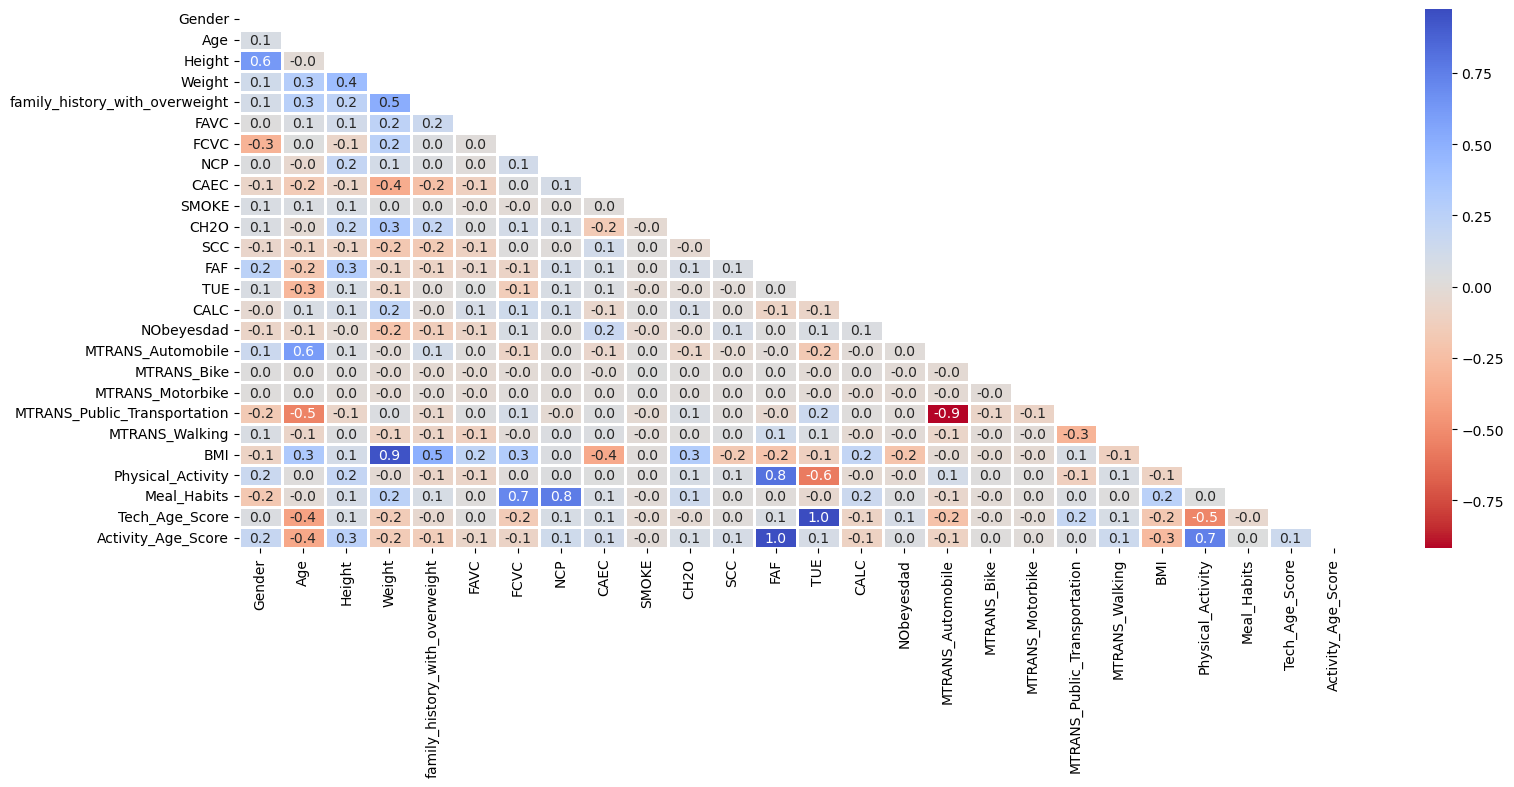

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (18,7))
sns.heatmap(df_train.corr(), annot=True, fmt=".1f", linewidth=1, cmap='coolwarm_r',
            mask=np.triu(np.ones_like(df_train.corr())));

## 3. Подготовка данных для построения модели

Выделим матрицу наблюдений и вектор целевой переменной:

In [14]:
X = df_train.drop('NObeyesdad', axis=1)
y = df_train['NObeyesdad']

Для оценки построения будем использовать стратифицированную кросс-валидацию, так сможем избежать переобучения и сохраним баланс классов на подвыборках:

In [51]:
from sklearn.model_selection import StratifiedKFold

# берем 5 фолдов
cv = StratifiedKFold(5, shuffle=True, random_state=42)
cv_splits = cv.split(X, y)

display(list(cv_splits))

[(array([    1,     3,     4, ..., 20755, 20756, 20757]),
  array([    0,     2,    14, ..., 20749, 20752, 20754])),
 (array([    0,     1,     2, ..., 20754, 20755, 20757]),
  array([    4,     7,    21, ..., 20751, 20753, 20756])),
 (array([    0,     1,     2, ..., 20755, 20756, 20757]),
  array([    8,    12,    15, ..., 20747, 20748, 20750])),
 (array([    0,     2,     4, ..., 20754, 20756, 20757]),
  array([    1,     3,     5, ..., 20741, 20744, 20755])),
 (array([    0,     1,     2, ..., 20754, 20755, 20756]),
  array([    9,    10,    11, ..., 20731, 20742, 20757]))]

Также отдельно сделаем по одной выборке для обучения и валидции: 

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (15568, 25)
X_valid shape: (5190, 25)


В качестве метрики будем использовть accuracy, классы более менее сбалансированы и эта метрика будет достаточно объективной и легко интерпретируемой + именно эта метрика используется для оценки результата на Kaggle. 

## 4. XGboost

Мы можем указать набор данных для валидации(train/valid) во время обучения и отслеживать результаты обучения. Также есть возможность задать  early_stopping_rounds, чтобы остановить обучение тогда, когда на валидации не происходит прироста качества:

In [76]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    
    n_estimators=1000, # кол-во деревьев
    max_depth=5, # глублина деревьев
    learning_rate=0.05, # на сколько сильно учитываем предыдущие дерево (скокрость обучения)
    
    subsample=1, # обучаемся на подвыборках (0.5 - случайная половина тренировочного набора)
    colsample_bytree=1, # какую часть колонок(фичей) берем в подвыборку обучения 
    
    reg_lambda=1, # регулязация, чем выше, тем консервативнее
    min_child_weight=1, # минимальная сумма веса экземпялра для дальнейшего сплита дерева, чем выше, тем консервативнее
    scale_pos_weight=1, #для баланса классов
    
    eval_metric='mlogloss', # метрика для оценки построения
    tree_method='hist', # метод построения дерева (hist простой и быстрый)
    objective='multi:softmax', # тип решения задачи (для мультиклассов указываем кол-во классов)
    num_class = 7, # кол-во классов

    n_jobs=-1, # использовать все ядра для обучения
    random_state=42, # для воспроизводимости результатов
    verbosity=0, # не вывоить отчёт
    early_stopping_rounds=50 # остановка если прироста на валидации больше нету (стоит брать как 10% от кол-ва деревьев)
)

xgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)], verbose=100);

print('accuracy on train:', accuracy_score(y_train, xgb.predict(X_train)))
print('accuracy on valid:', accuracy_score(y_valid, xgb.predict(X_valid)))

[0]	validation_0-mlogloss:1.81406	validation_1-mlogloss:1.81518
[100]	validation_0-mlogloss:0.26515	validation_1-mlogloss:0.31403
[200]	validation_0-mlogloss:0.19449	validation_1-mlogloss:0.27998
[300]	validation_0-mlogloss:0.15569	validation_1-mlogloss:0.27545
[378]	validation_0-mlogloss:0.13218	validation_1-mlogloss:0.27591
accuracy on train: 0.951374614594039
accuracy on valid: 0.9065510597302505


Можем отобразить процесс обучения и отметить раннию остановку: 

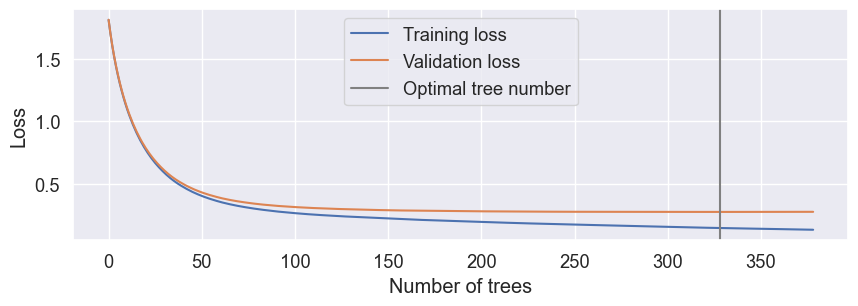

In [77]:
xgb_results = xgb.evals_result()

plt.figure(figsize=(10,3))
plt.plot(xgb_results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(xgb_results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(xgb.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

Проверим качество модели на нашей кросс-валидации:

In [55]:
from sklearn.model_selection import cross_validate

xgb = XGBClassifier(   
    n_estimators=1000, 
    max_depth=5, 
    learning_rate=0.05, 
    tree_method='hist', 
    objective='multi:softmax',
    num_class = 7, 
    n_jobs=-1,
    random_state=42,
)

cv_splits = cv.split(X, y) 
cv_results = cross_validate(xgb, X, y, cv=cv_splits, scoring='accuracy')

# результат берем как среднее на всех фолдах
accuracy_mean = cv_results['test_score'].mean()
print(f'Cross-validated Accuracy: {accuracy_mean:.3f}')

Cross-validated Accuracy: 0.905


Сделаем предсказание классов на кросс-валидации и выведем подробный отчет по классификации:

In [67]:
from sklearn.model_selection import cross_val_predict

cv_splits = cv.split(X, y) 
cv_predict = cross_val_predict(xgb, X, y, cv=cv_splits)

target_names = ['Normal_Weight','Obesity_Type_I','Obesity_Type_II', 'Obesity_Type_III','Overweight_Level_I','Overweight_Level_II','Insufficient_Weight']

print(classification_report(y_true=y, y_pred=cv_predict, target_names=target_names))

                     precision    recall  f1-score   support

      Normal_Weight       0.87      0.88      0.88      3082
     Obesity_Type_I       0.89      0.89      0.89      2910
    Obesity_Type_II       0.97      0.97      0.97      3248
   Obesity_Type_III       1.00      1.00      1.00      4046
 Overweight_Level_I       0.81      0.77      0.79      2427
Overweight_Level_II       0.81      0.82      0.81      2522
Insufficient_Weight       0.93      0.93      0.93      2523

           accuracy                           0.91     20758
          macro avg       0.90      0.89      0.90     20758
       weighted avg       0.90      0.91      0.91     20758



Построим матрицу ошибок:

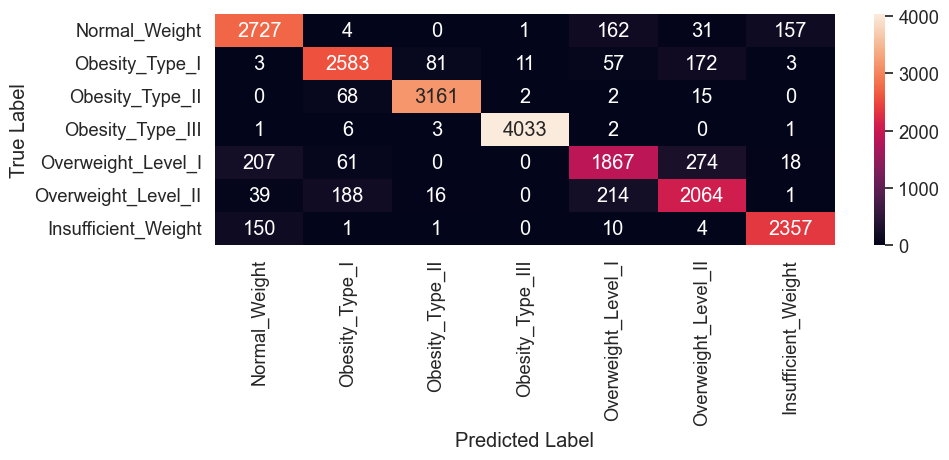

In [72]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y, y_pred=cv_predict)

plt.figure(figsize=(10, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

XGboost показал неплохой результат фактически сразу "из коробки". Подберём оптимальные гиперпараметры с помощью optuna.

## 5 Optuna optimization

In [81]:
import optuna
from optuna.samplers import TPESampler

# определяем функцию для перебора параметров 
def objective(trial):
    # параметры для перебора    
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma' : trial.suggest_float('gamma', 1e-9, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),       
    }

    # зафиксируем часть параметров
    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params["verbosity"] = 0
    params['tree_method'] = "hist"
    params['random_state'] = 42
    # модель, передаем в неё сетку параметров
    xgb = XGBClassifier(**params)

    # оценивать качество будем на кросс-валидации
    cv_splits = cv.split(X, y)
    cv_scores= cross_validate(xgb, X, y, cv=cv_splits, scoring='accuracy')
    # считаем результат как среднее по фолдам
    cv_evaluation = np.mean(np.abs(cv_scores['test_score']))

    return cv_evaluation

# чтобы не выводить процесс обучения
optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler=TPESampler - метод поиска оптимальных значений (Tree-structured Parzen Estimator)
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42),
                            direction="maximize")

# запускаем оптимизацию, берем 40 итераций
study.optimize(objective, n_trials=40)

# результаты оптимизации
print(f"best optmized accuracy: {study.best_value:0.5f}")
print(f"best hyperparameters: {study.best_params}")

C:\Users\d.sergeev\AppData\Roaming\Python\Python311\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


best optmized accuracy: 0.90900
best hyperparameters: {'grow_policy': 'lossguide', 'n_estimators': 835, 'learning_rate': 0.013336999755390369, 'gamma': 0.1767263332979827, 'subsample': 0.7382813044115208, 'colsample_bytree': 0.6393871797467892, 'max_depth': 12, 'min_child_weight': 7, 'reg_lambda': 2.6079100312858614e-08, 'reg_alpha': 0.6414315229851367}


Обучаем финальную модель с найденными гиперпараметрами:

In [82]:
best_cls_params = study.best_params
best_cls_params['booster'] = 'gbtree'
best_cls_params['objective'] = 'multi:softmax'
best_cls_params["verbosity"] = 0
best_cls_params['tree_method'] = "hist"
best_cls_params['random_state'] = 42

xgb = XGBClassifier(**best_cls_params)
xgb.fit(X, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6393871797467892, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1767263332979827,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.013336999755390369,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=835, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Для XGboost есть возможность вывести значимость переменных:

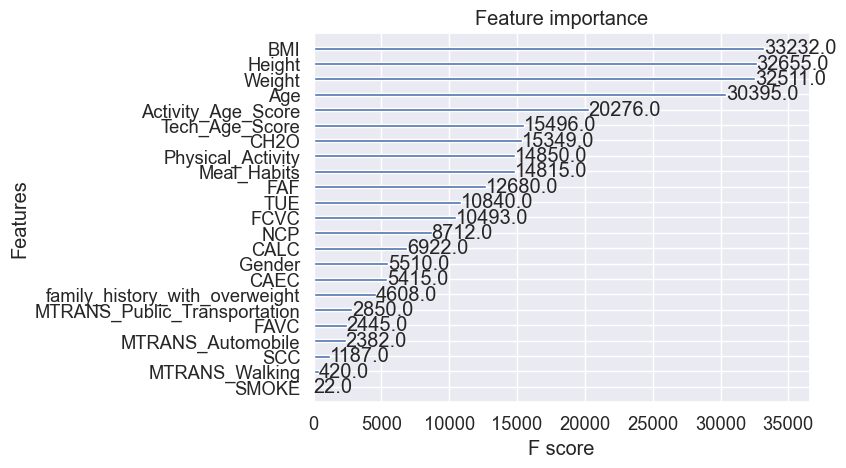

In [95]:
# можно получить значения с помощью xgb.feature_importances_ или импортировать специальную функцию
from xgboost import plot_importance
plot_importance(xgb);

## 6. SAMPLE SUBMISSION

In [99]:
# делаем предсказание на тестовом наборе данных
predict = xgb.predict(df_test)

# сопоставляем прдсказания с id строк, возращаем название классов
sample_submission = pd.DataFrame({'id':id_sample_submission,
                                    'NObeyesdad':predict})

# возращаем название классов
sample_submission['NObeyesdad'] = sample_submission['NObeyesdad'].apply(get_target)
sample_submission

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [100]:
# сохраняем результат
sample_submission.to_csv('sample_submission_5.csv', index=False)